# Identify Factors That Influence Corruption With The Use Of Machine Learning

**Overview:** 

The objective of this project is to identify and inference/understand various socioeconomic and political factors that might influence the corruption perception index (CPI) per country view. 

The discovery of these potential indicators can provide valuable insights to develop effective strategies to mitigate corruption and promote transparency.

**Methodology:** 

The methodology used on this project follows a CRISP-DM approach. On this notebook is providing with the steps and the README.md. 

The README.md file contains the Business Understanding and Conclusions. 

This notebook contains:
- Data understanding
- Data preparation
- Benchmarking different models
- Conclusions



## Data Understanding and Preparation

The goal is to understand the characteristics, patterns, and anomalies that our datasets might contain 

### Data Sources

The datasources used for these excercise are the following:

1. [Corruption Perceptions Index (CPI)](https://www.transparency.org/en/cpi) - Transparency International
2. [World Development Indicators (WDI)](https://databank.worldbank.org/source/world-development-indicators) - World Bank's Open Data


In [80]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import imageio.v2 as imageio
import kaleido


### Corruption Perceptions Index by Transparency International

- **Data Source:** [Transparency International's CPI](https://www.transparency.org/en/cpi).
- **Description:** The CPI is a composite index that ranks countries and territories based on their public sector's perceived corruption levels. The index is formed from a combination of surveys and corruption assessments sourced from various respected institutions, making it globally recognized as a leading corruption indicator. The index is scored on a scale of 0 (highly corrupt) to 100 (very clean).
- **Limitations:** The CPI is perception-based and does not directly measure corruption levels. Instead, it compiles data from different sources, capturing the views of business people and country experts on the public sector's corruption levels. As such, the CPI should not be viewed as a definitive judgment of a society's overall corruption levels but as an evaluation of public sector corruption.
- **Collection Methodology:** The CPI is derived from 13 surveys and assessments from 12 independent institutions. These sources typically define corruption as "the misuse of public power for private benefit." A country must have at least three data sources available for a given year to receive a CPI score.
- **Update Frequency:** Transparency International publishes the CPI annually.
- **Use Note:** CPI scores prior to 2012 are not directly comparable with scores from subsequent years due to methodology changes. Thus, these scores will not be utilized in our analysis.


In [81]:
# get Transparency International CPI data from local file
# https://www.transparency.org/en/cpi/2022

CPI = pd.read_csv('data/CPI2022_GlobalResultsTrends.csv', header=0)

display(CPI.head())
display(CPI.tail())
display(CPI.info())

,Country / Territory,ISO3,Region,Year,CPI score,Rank,Sources,Standard error
0,Afghanistan,AFG,AP,2012,8,NaN,3,3.30
1,Afghanistan,AFG,AP,2013,8,NaN,3,3.30
2,Afghanistan,AFG,AP,2014,12,NaN,4,1.29
3,Afghanistan,AFG,AP,2015,11,NaN,4,3.49
4,Afghanistan,AFG,AP,2016,15,NaN,5,1.74


,Country / Territory,ISO3,Region,Year,CPI score,Rank,Sources,Standard error
1944,Zimbabwe,ZWE,SSA,2018,22,160.0,9,2.290000
1945,Zimbabwe,ZWE,SSA,2019,24,158.0,9,2.307745
1946,Zimbabwe,ZWE,SSA,2020,24,157.0,9,1.352586
1947,Zimbabwe,ZWE,SSA,2021,23,157.0,8,1.518090
1948,Zimbabwe,ZWE,SSA,2022,23,157.0,8,1.532080


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country / Territory  1949 non-null   object 
 1   ISO3                 1949 non-null   object 
 2   Region               1949 non-null   object 
 3   Year                 1949 non-null   int64  
 4   CPI score            1949 non-null   int64  
 5   Rank                 1080 non-null   float64
 6   Sources              1949 non-null   int64  
 7   Standard error       1949 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 121.9+ KB


None

##### Selecting relevant data for our interes:

Will be only using CPI scores from 2012 to 2020. 

We will also drop the `Rank`, `Standard Error`, and `Number of Sources` columns since they are not relevant for our analysis.

In [82]:
# drop columns that are not needed
CPI.drop(['Rank', 'Sources', 'Standard error'], axis=1, inplace=True)

##### Checking for duplicate or missing values and deciding on the imputation strategy if required.

In [83]:
# Check for missing values per feature
print(f'Missing value: \n{CPI.isnull().sum()}')

# Check for duplicate rows
print(f'Duplicate rows: {CPI.duplicated().sum()}')

Missing value: 
Country / Territory    0
ISO3                   0
Region                 0
Year                   0
CPI score              0
dtype: int64
Duplicate rows: 0


##### Check completeness from the years of interests and availability per country basis

In [84]:
# Create a dataframe with all possible combinations of ISO3 and Year
all_countries = CPI['ISO3'].unique()
all_years = np.arange(2012, 2023)  # adjust the years as needed

# Merge with original dataframe to include all CPI scores
df_full = pd.merge(pd.DataFrame(index=pd.MultiIndex.from_product([all_countries, all_years], names=['ISO3', 'Year'])).reset_index(), 
                   CPI, on=['ISO3', 'Year'], how='left')

# df_full[df_full['CPI score'].isnull()][['ISO3', 'Year']].groupby('ISO3').count()
fullMatrix = df_full.pivot(index='ISO3', columns='Year', values='CPI score')

# display fullMatrix rows where at least one value is missing
display(fullMatrix[fullMatrix.isnull().any(axis=1)])

Year,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
ISO3,,,,,,,,,,,
BHS,71.0,71.0,71.0,NaN,66.0,65.0,65.0,64.0,63.0,64.0,64.0
BRB,76.0,75.0,74.0,NaN,61.0,68.0,68.0,62.0,64.0,65.0,65.0
BRN,55.0,60.0,NaN,NaN,58.0,62.0,63.0,60.0,60.0,NaN,NaN
DMA,58.0,58.0,58.0,NaN,59.0,57.0,57.0,55.0,55.0,55.0,55.0
FJI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,53.0
GNQ,20.0,19.0,NaN,NaN,NaN,17.0,16.0,16.0,16.0,17.0,17.0
GRD,NaN,NaN,NaN,NaN,56.0,52.0,52.0,53.0,53.0,53.0,52.0
LCA,71.0,71.0,71.0,NaN,60.0,55.0,55.0,55.0,56.0,56.0,55.0
MDV,NaN,NaN,NaN,NaN,36.0,33.0,31.0,29.0,43.0,40.0,40.0


- Fidji is missing most of its values (9 years out of 11). We will drop this country from our analysis.
- Every other country has data for at least the last 6 years.

In [85]:
# drop Fiji related records
CPI.drop(CPI[CPI['ISO3'] == 'FJI'].index, inplace=True)
df_full.drop(df_full[df_full['ISO3'] == 'FJI'].index, inplace=True)

##### Checking consistency of ISO codes and country names across datasets.


In [86]:
print(CPI[['ISO3','Country / Territory']].nunique())
print(CPI.groupby(['ISO3','Country / Territory']).count().shape)

ISO3                   180
Country / Territory    180
dtype: int64
(180, 3)


- `ISO3` and `Country` columns are matching 1 to 1. We will keep the `Country / Territory` only for description. However, we will not use it for our analysis and we will use the `ISO3` code as index for analysis and to merge our datasets.

##### Analyse Distribution and Check for outliers 

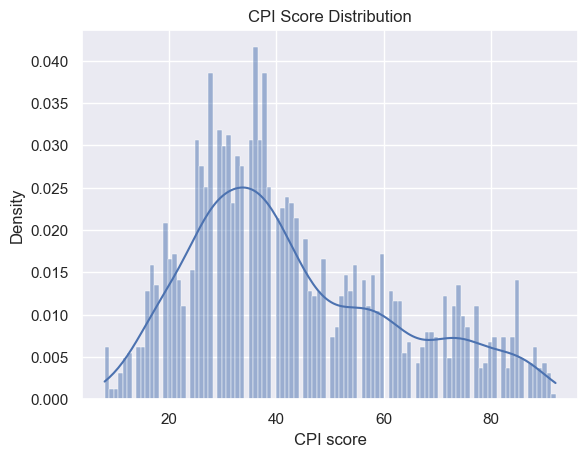

,Year,CPI score
count,1947.000000,1947.000000
mean,2017.040062,43.023112
std,3.162349,19.277547
min,2012.000000,8.000000
25%,2014.000000,29.000000
50%,2017.000000,38.000000
75%,2020.000000,56.000000
max,2022.000000,92.000000


In [87]:
#sns.histplot(data=CPI, x='CPI score', kde=True, bins=40, stat="density")
sns.histplot(data=CPI, x='CPI score', kde=True, bins=100, stat="density")
plt.title('CPI Score Distribution')
plt.show()

display(CPI.describe())

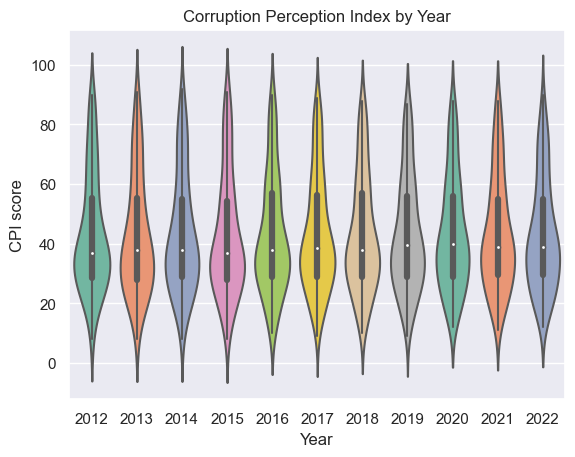

In [88]:
# Draw Corruption Perception Index (CPI) distribution
sns.set_theme(style="darkgrid")
ax = sns.violinplot(x="Year", y="CPI score", data=CPI,  palette="Set2")
plt.title('Corruption Perception Index by Year')
plt.show()

- The CPI is scored on a scale of 0 (highly corrupt) to 100 (very clean). 
- The distribution of the CPI scores is skewed to the left, with a mean of 43. The minimum score is 8, and the maximum score is 92.
- Distribution of CPI is similar across years.
- There are no outliers in the CPI dataset.

##### Distribution by Region

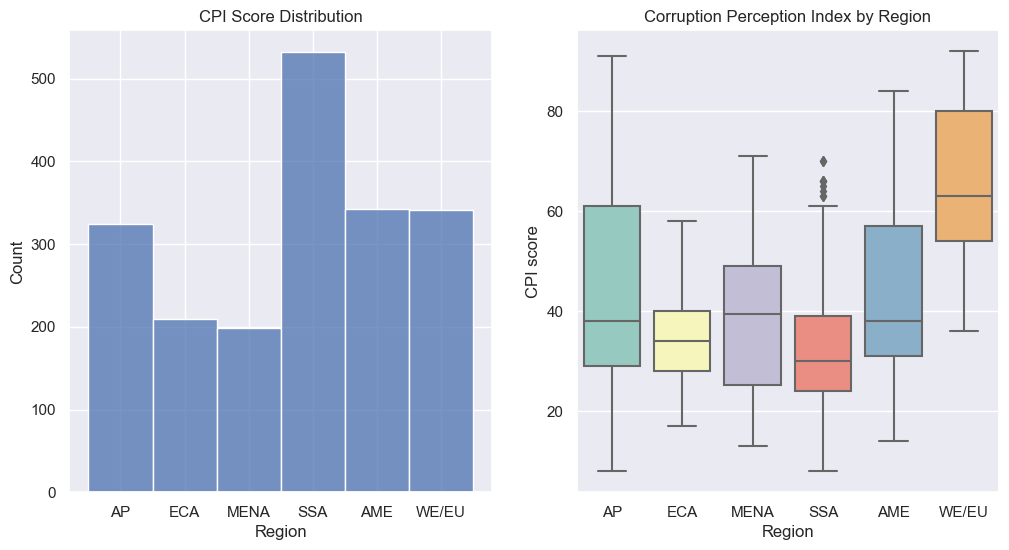

In [89]:
# Create a grid of subplots with 1 row and 2 columns
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the histogram in the first subplot
sns.histplot(data=CPI, x='Region', kde=False, bins=120, ax=axs[0])
axs[0].set_title('CPI Score Distribution')

# Plot the boxplot in the second subplot
sns.boxplot(x="Region", y="CPI score", data=CPI, palette="Set3", ax=axs[1])
axs[1].set_title('Corruption Perception Index by Region')

# Display the figure
plt.show()

- `Region` could be relevant for our analysis. However, the information is also available in the World Bank dataset. As it is widely used by international institutions, we will use the `Region` information from World Bank.

##### Corruption Perception Index On World Perspective

In [90]:
# draw animated colopeth map of CPI score by country over time
fig = px.choropleth(CPI, locations="ISO3", color="CPI score", hover_name="Country / Territory", animation_frame="Year",
                    color_continuous_scale=px.colors.sequential.Darkmint
                    , range_color=[0, 100]
                    , title="CPI by Country 2012-2022"
                    , width=800, height=520)
fig.update_layout(margin={"l": 10,"r": 10, "t": 40,  "b": 1})
fig.add_annotation(x=1, y=-0.08, xref='paper', yref='paper', text='Source:<a href="https://www.transparency.org/en/cpi/2022">Transparency International</a>', showarrow=False)

fig.show()

### World Bank Indicators

- **Data Source:** [World Bank's Open Data](https://databank.worldbank.org/source/world-development-indicators)
- **Description:** The World Bank Indicators encompass a wide range of economic, social, and environmental data about World Bank member countries and other economies. These indicators include metrics like GDP, education, health, labor, trade, and numerous others, offering comprehensive insights into various development aspects globally. Each indicator has a specific scale relevant to the data it presents. The dataset provided for this analysis contains 1,478 indicators addressing over 90 topics.
- **Limitations:** While these indicators offer valuable insights, they come with certain limitations, including varying data quality across countries, potential errors due to statistical estimation techniques, and some data being outdated or missing for certain countries or years.
- **Collection Methodology:** The World Bank sources data from various national and international sources, including statistical publications and databases maintained by countries, UN agencies, various international and regional organizations, and academic sources. The data undergoes rigorous quality checks before being made available on the platform.
- **Update Frequency:** The World Bank continuously updates its datasets as fresh data becomes available, though the frequency can vary depending on the data source and indicator.


In [91]:
# Read csv from zip file
WDI = pd.read_csv('data/WDIData.zip')

display(WDI.head(5))
display(WDI['Indicator Name'].unique().shape)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,17.196986,17.597176,18.034249,18.345878,18.695306,19.149942,19.501837,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.580066,6.786218,6.941323,7.096843,7.254828,7.460783,7.599289,NaN,NaN,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,37.857526,38.204173,38.303515,38.421813,38.482409,38.692053,38.793983,NaN,NaN,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,31.824950,33.744405,38.733352,40.092163,42.880977,44.073912,45.609604,NaN,NaN,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,17.485006,16.329765,24.372504,25.153292,27.227391,29.383000,30.163364,NaN,NaN,NaN


(1478,)

##### Filter Relevant Data for our interes / analysis:

With more than 1,400 indicators available, we will need to select the most relevant features for our analysis. 

The criteria to be used is the following:

- **Relevance:** We will only use indicators that are relevant to our analysis. 
- **Availability:** We will only use indicators that are available for most countries and years. 
- **Correlation:** We will only use indicators that are not highly correlated with each other.

- Based on CPI scores availability (2012 to 2020). We will only use the World Bank Indicators from 2012 to 2020 at country level (no regional or global data). 
- Will also exclude countries that are not present in the CPI dataset
- Column Unnamed: 67 is empty and will be dropped.

In [92]:
WDI = WDI[['Country Code', 'Country Name', 'Indicator Code', 'Indicator Name', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']]
WDI.rename(columns={'Country Code': 'ISO3'}, inplace=True)
# only keep the rows with ISO3 in CPI
WDI = WDI[WDI['ISO3'].isin(CPI['ISO3'].unique())]

display(WDI.info())
display(WDI.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263084 entries, 72422 to 393147
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ISO3            263084 non-null  object 
 1   Country Name    263084 non-null  object 
 2   Indicator Code  263084 non-null  object 
 3   Indicator Name  263084 non-null  object 
 4   2012            170693 non-null  float64
 5   2013            168755 non-null  float64
 6   2014            173752 non-null  float64
 7   2015            172772 non-null  float64
 8   2016            170335 non-null  float64
 9   2017            167482 non-null  float64
 10  2018            166113 non-null  float64
 11  2019            159551 non-null  float64
 12  2020            142168 non-null  float64
 13  2021            108364 non-null  float64
 14  2022            12192 non-null   float64
dtypes: float64(11), object(4)
memory usage: 32.1+ MB


None

,ISO3,Country Name,Indicator Code,Indicator Name,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
72422,AFG,Afghanistan,EG.CFT.ACCS.ZS,Access to clean fuels and technologies for coo...,23.000000,24.800000,26.100000,27.400000,28.600000,29.700000,30.900000,31.900000,33.200000,NaN,NaN
72423,AFG,Afghanistan,EG.CFT.ACCS.RU.ZS,Access to clean fuels and technologies for coo...,8.200000,9.100000,10.200000,11.100000,12.200000,13.000000,13.850000,15.100000,15.900000,NaN,NaN
72424,AFG,Afghanistan,EG.CFT.ACCS.UR.ZS,Access to clean fuels and technologies for coo...,74.400000,75.700000,77.600000,78.800000,79.700000,80.900000,81.600000,82.300000,82.600000,NaN,NaN
72425,AFG,Afghanistan,EG.ELC.ACCS.ZS,Access to electricity (% of population),69.099998,68.290649,89.500000,71.500000,97.699997,97.699997,96.616135,97.699997,97.699997,NaN,NaN
72426,AFG,Afghanistan,EG.ELC.ACCS.RU.ZS,"Access to electricity, rural (% of rural popul...",60.849155,60.566135,86.500511,64.573357,97.099358,97.091972,95.586174,97.075630,97.066711,NaN,NaN


#### Extending WDI Dataset with the Country's region and Income group Dataset

In [93]:
# Extending the WDI dataset with the information regarding the country's region and income group from World Bank Country Info dataset
Country_info = pd.read_csv('data/Country.csv')
Country_info = Country_info[['Code', 'Region', 'Income group']]
Country_info.rename(columns={'Code': 'ISO3'}, inplace=True)
Country_info.head()

# Merge WDI with Country_info
WDI = pd.merge(WDI, Country_info, on='ISO3', how='left')
WDI.head()

,ISO3,Country Name,Indicator Code,Indicator Name,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,Region,Income group
0,AFG,Afghanistan,EG.CFT.ACCS.ZS,Access to clean fuels and technologies for coo...,23.000000,24.800000,26.100000,27.400000,28.600000,29.700000,30.900000,31.900000,33.200000,NaN,NaN,South Asia,Low income
1,AFG,Afghanistan,EG.CFT.ACCS.RU.ZS,Access to clean fuels and technologies for coo...,8.200000,9.100000,10.200000,11.100000,12.200000,13.000000,13.850000,15.100000,15.900000,NaN,NaN,South Asia,Low income
2,AFG,Afghanistan,EG.CFT.ACCS.UR.ZS,Access to clean fuels and technologies for coo...,74.400000,75.700000,77.600000,78.800000,79.700000,80.900000,81.600000,82.300000,82.600000,NaN,NaN,South Asia,Low income
3,AFG,Afghanistan,EG.ELC.ACCS.ZS,Access to electricity (% of population),69.099998,68.290649,89.500000,71.500000,97.699997,97.699997,96.616135,97.699997,97.699997,NaN,NaN,South Asia,Low income
4,AFG,Afghanistan,EG.ELC.ACCS.RU.ZS,"Access to electricity, rural (% of rural popul...",60.849155,60.566135,86.500511,64.573357,97.099358,97.091972,95.586174,97.075630,97.066711,NaN,NaN,South Asia,Low income


- Indicators that are representing standard error, ranking or number of sources will be dropped as they are not relevant for this analysis.

- Similarly, we will drop indicators that are expressed in local currency as we will focus on the relative value of the indicators.

- CPIA transparency, accountability, and corruption in the public sector rating will be droped as CPI is one of the component for this indicator


In [94]:
# drop each records when indicator contains ".STD.ERR" or ".RNK" or ".SRC"
WDI = WDI[~WDI['Indicator Code'].str.contains('.STD.ERR|.RNK|.SRC')] # Standard error, rank, number of source
WDI = WDI[~WDI['Indicator Name'].str.contains('LCU')] # Local Currency Unit
# drop IQ.CPA.TRAN.XQ (CPIA transparency, accountability, and corruption in the public sector rating (1=low to 6=high)) and CC.EST (Control of Corruption: Estimate) as CPI is one of the input for those indicator
WDI = WDI[~WDI['Indicator Code'].str.contains('IQ.CPA.TRAN.XQ')]
WDI = WDI[~WDI['Indicator Code'].str.contains('CC.EST')]

#### Data Clean Up 

Missing and Duplicates identification and imputation strategy when required.

In [95]:
# Check for duplicate rows
print(f'Duplicate rows: {WDI.duplicated().sum()}')

# Check for missing values per feature
print(f'Missing value: \n{WDI.isnull().sum()}')

Duplicate rows: 0
Missing value: 
ISO3                   0
Country Name           0
Indicator Code         0
Indicator Name         0
2012               88779
2013               90663
2014               85749
2015               86779
2016               89179
2017               91924
2018               93153
2019               99548
2020              116595
2021              149315
2022              229512
Region                 0
Income group        1355
dtype: int64


In [96]:
WDI[WDI['Income group'].isnull()]['ISO3'].unique()

array(['VEN'], dtype=object)

- Since 2021, `Venezuela`, previously classified as a an `upper-middle income` country, is now unclassified due to a lack of available data in the recent period.(Source: [World Bank](https://blogs.worldbank.org/opendata/new-world-bank-country-classifications-income-level-2021-2022))

- We will classify `Venezuela` as a `upper-middle income` country for our analysis.

In [97]:
# set Income group to "Upper middle income" for Venezuela
WDI.loc[WDI['ISO3'] == 'VEN', 'Income group'] = 'Upper middle income'

In [98]:
# Check for missing values per indicator
WDI2 = WDI.drop(columns=['Indicator Code']).melt(id_vars=['ISO3', 'Region', 'Country Name', 'Income group', 'Indicator Name'], var_name='Year', value_name='Value', ignore_index=False)
WDI2['Year'] = WDI2['Year'].astype(int)

display((WDI2['Value'].isnull().sum() / len(WDI2)).mean())

# pivot table to get indicators as features
WDI2 = WDI2.pivot_table(index=['ISO3', 'Country Name', 'Region', 'Income group', 'Year'], columns='Indicator Name', values='Value').reset_index()

0.4602919614487258

- `46%` of the data is missing. We will need to impute missing values for our analysis.

- Will be using the impute missing values using the `Interpolation` method. This method is appropriate for our dataset since the data is time-series and the missing values are likely to be close to the existing values.

- Will also impute missing values for the first and last years using the `forward-fill` and `backward-fill` methods, respectively. This is because the interpolation method cannot be used for the first and last years since there are no values before or after them to interpolate from.

- In order to limit imputation bias, we will only impute missing values for indicators that have less than 50% of missing values. We will drop the remaining indicators from our analysis.

- The remaining missing values will filled with the mean of the indicator. However, if the indicator has more than 20% of missing values after interpolation, we will drop it from our analysis.

In [99]:
# drop features with more than 50% missing values
WDI2.dropna(thresh=WDI2.shape[0]*.5, axis=1, inplace=True)

# get list of indicator features
features = WDI2.drop(['ISO3', 'Country Name', 'Region', 'Income group', 'Year'],axis=1).columns
WDI2.sort_values(by=['ISO3', 'Year'], inplace=True)

# interpolate missing values
for feature in features:
    # interpolate missing values
    WDI2[feature] = WDI2.groupby('ISO3')[feature].apply(lambda group: group.interpolate())
    # fill remaining missing values with forward fill method
    WDI2[feature] = WDI2.groupby('ISO3')[feature].ffill()
    # fill remaining missing values with backward fill method
    WDI2[feature] = WDI2.groupby('ISO3')[feature].bfill()

    # if more than 20% missing values after interpolation, drop the feature else fill remaining missing values with mean
    if (WDI2[feature].isnull().sum() / len(WDI2)) > 0.2:
        WDI2.drop(columns=feature, inplace=True)
    else:
        WDI2[feature].fillna(WDI2[feature].mean(), inplace=True)

/var/folders/jc/s52zkjgs0jgbmgblzfhy27q80000gr/T/ipykernel_99982/4177737562.py:11: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

/var/folders/jc/s52zkjgs0jgbmgblzfhy27q80000gr/T/ipykernel_99982/4177737562.py:11: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

/var/folders/jc/s52zkjgs0jgbmgblzfhy27

#### Merge Both Datasets CPI and WDI

In [100]:
# merge WDI and CPI
df = pd.merge(CPI[['ISO3','Year','CPI score']], WDI2, on=['ISO3', 'Year'], how='inner')
df.head()

,ISO3,Year,CPI score,Country Name,Region,Income group,Access to clean fuels and technologies for cooking (% of population),"Access to clean fuels and technologies for cooking, rural (% of rural population)","Access to clean fuels and technologies for cooking, urban (% of urban population)",Access to electricity (% of population),...,Voice and Accountability: Estimate,"Vulnerable employment, female (% of female employment) (modeled ILO estimate)","Vulnerable employment, male (% of male employment) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Wage and salaried workers, female (% of female employment) (modeled ILO estimate)","Wage and salaried workers, male (% of male employment) (modeled ILO estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)","Water productivity, total (constant 2015 US$ GDP per cubic meter of total freshwater withdrawal)",Women Business and the Law Index Score (scale 1-100),Women's share of population ages 15+ living with HIV (%)
0,AFG,2012,8,Afghanistan,South Asia,Low income,23.0,8.2,74.4,69.099998,...,-1.267430,97.11668,85.10945,87.01582,2.585614,13.69351,11.92990,0.895943,28.750,28.9
1,AFG,2013,8,Afghanistan,South Asia,Low income,24.8,9.1,75.7,68.290649,...,-1.240068,96.37859,83.71615,85.83695,3.169307,14.85892,12.90104,0.946122,28.750,28.8
2,AFG,2014,12,Afghanistan,South Asia,Low income,26.1,10.2,77.6,89.500000,...,-1.135440,95.28894,82.17971,84.49434,4.023759,16.11819,13.98273,0.971900,28.750,28.7
3,AFG,2015,11,Afghanistan,South Asia,Low income,27.4,11.1,78.8,71.500000,...,-1.117557,93.81688,80.56573,83.03166,5.163307,17.43726,15.15319,0.986005,28.750,28.7
4,AFG,2016,15,Afghanistan,South Asia,Low income,28.6,12.2,79.7,97.699997,...,-1.037788,91.99834,78.86773,81.44670,6.491346,18.77817,16.36492,1.008292,38.125,28.8


#### Visualizing the Data Distribution From Our Datasets

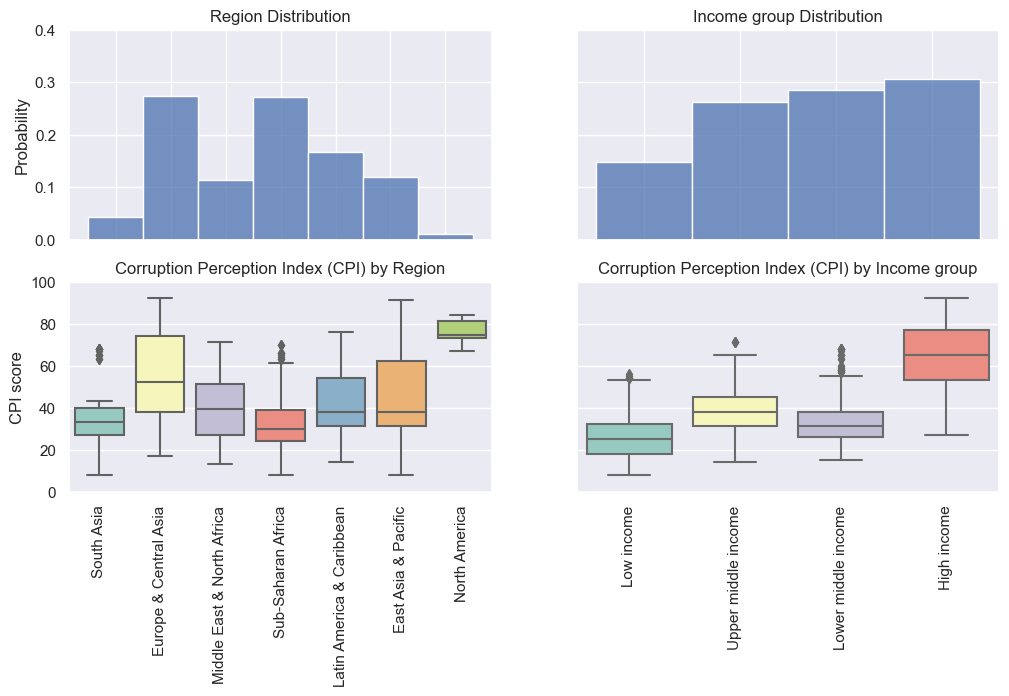

In [101]:
# View distribution of Region and Income group
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 6))

# flatten the axs array
axs = axs.flatten()

# Plot the histogram in the first subplot
sns.histplot(data=df, x='Region', kde=False, bins=40, stat="probability", ax=axs[0])
axs[0].set_title('Region Distribution')
axs[0].set_xticklabels([])
axs[0].set_xlabel(None)
axs[0].set_ylim(0, 0.4)

sns.histplot(data=df, x='Income group', kde=False, bins=40, stat="probability", ax=axs[1])
axs[1].set_title('Income group Distribution')
axs[1].set_xticklabels([])
axs[1].set_xlabel(None)
axs[1].set_ylim(0, 0.4)
axs[1].set_yticklabels([])
axs[1].set_ylabel(None)

# Plot the boxplot in the second subplot
sns.boxplot(x="Region", y="CPI score", data=df, palette="Set3", ax=axs[2])
axs[2].set_title('Corruption Perception Index (CPI) by Region')
axs[2].tick_params(axis='x', rotation=90)
axs[2].set_ylim(0, 100)
axs[2].set_xlabel(None)

# Plot the boxplot in the second subplot
sns.boxplot(x="Income group", y="CPI score", data=df, palette="Set3", ax=axs[3])
axs[3].set_title('Corruption Perception Index (CPI) by Income group')
axs[3].tick_params(axis='x', rotation=90)
axs[3].set_ylim(0, 100)
axs[3].set_yticklabels([])
axs[3].set_ylabel(None)
axs[3].set_xlabel(None)

# Display the figure
plt.show()


#### Feature correlation

With more than 1,400 indicators available, it is very likely that many of them are highly correlated with each other. 

We will need to identify and drop these some indicators from our analysis.


/var/folders/jc/s52zkjgs0jgbmgblzfhy27q80000gr/T/ipykernel_99982/672405446.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



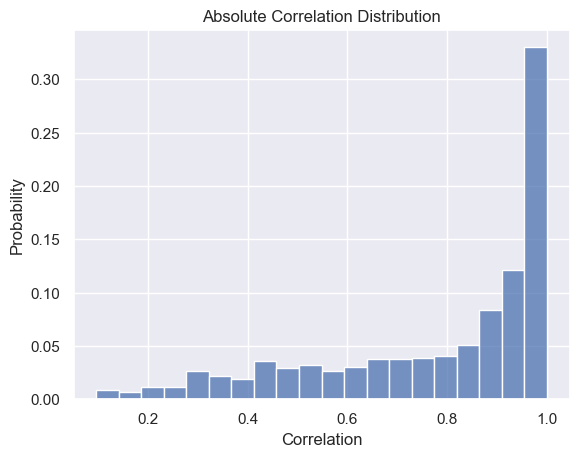

In [102]:
corr_matrix = df.drop(['Year','CPI score'],axis=1).corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

corr_stack = tri_df.stack().reset_index().sort_values(0, ascending=False)
corr_stack.rename(columns={'level_0':'Feature 1', 'level_1':'Feature 2', 0:'Correlation'}, inplace=True)
corr_stack = corr_stack[corr_stack['Feature 1'] != corr_stack['Feature 2']]
corr_stack.head(100)
max_corr = corr_stack.groupby('Feature 1').max().reset_index()

# display distribution of Correlation
sns.histplot(data=max_corr, x='Correlation', kde=False, bins=20, stat="probability")
plt.title('Absolute Correlation Distribution')
plt.show()

As expected, there is a high correlation between the indicators. We will need to drop some of them from our analysis to reduce multicollinearity.

We will drop indicators that are highly correlated with other indicators. We will keep the indicator that is the least correlated with the other indicators.


In [103]:
threshold = .80
# Calculate the correlation matrix
corr_matrix = df.corr().abs()

# Create a mask to ignore self-
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

# List of features to be removed
to_drop = []

# Iterate over the features
for column in tri_df.columns:
    if column not in to_drop :
        to_drop.extend(tri_df[column][tri_df[column] > threshold].index)

# Drop the features
df.drop(to_drop, axis=1, inplace=True)
print(f'Number of features left: {len(df.columns)}')

/var/folders/jc/s52zkjgs0jgbmgblzfhy27q80000gr/T/ipykernel_99982/604758727.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Number of features left: 312


##### Visualize the most correlated remaining indicators

/var/folders/jc/s52zkjgs0jgbmgblzfhy27q80000gr/T/ipykernel_99982/3769816114.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/jc/s52zkjgs0jgbmgblzfhy27q80000gr/T/ipykernel_99982/3769816114.py:12: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



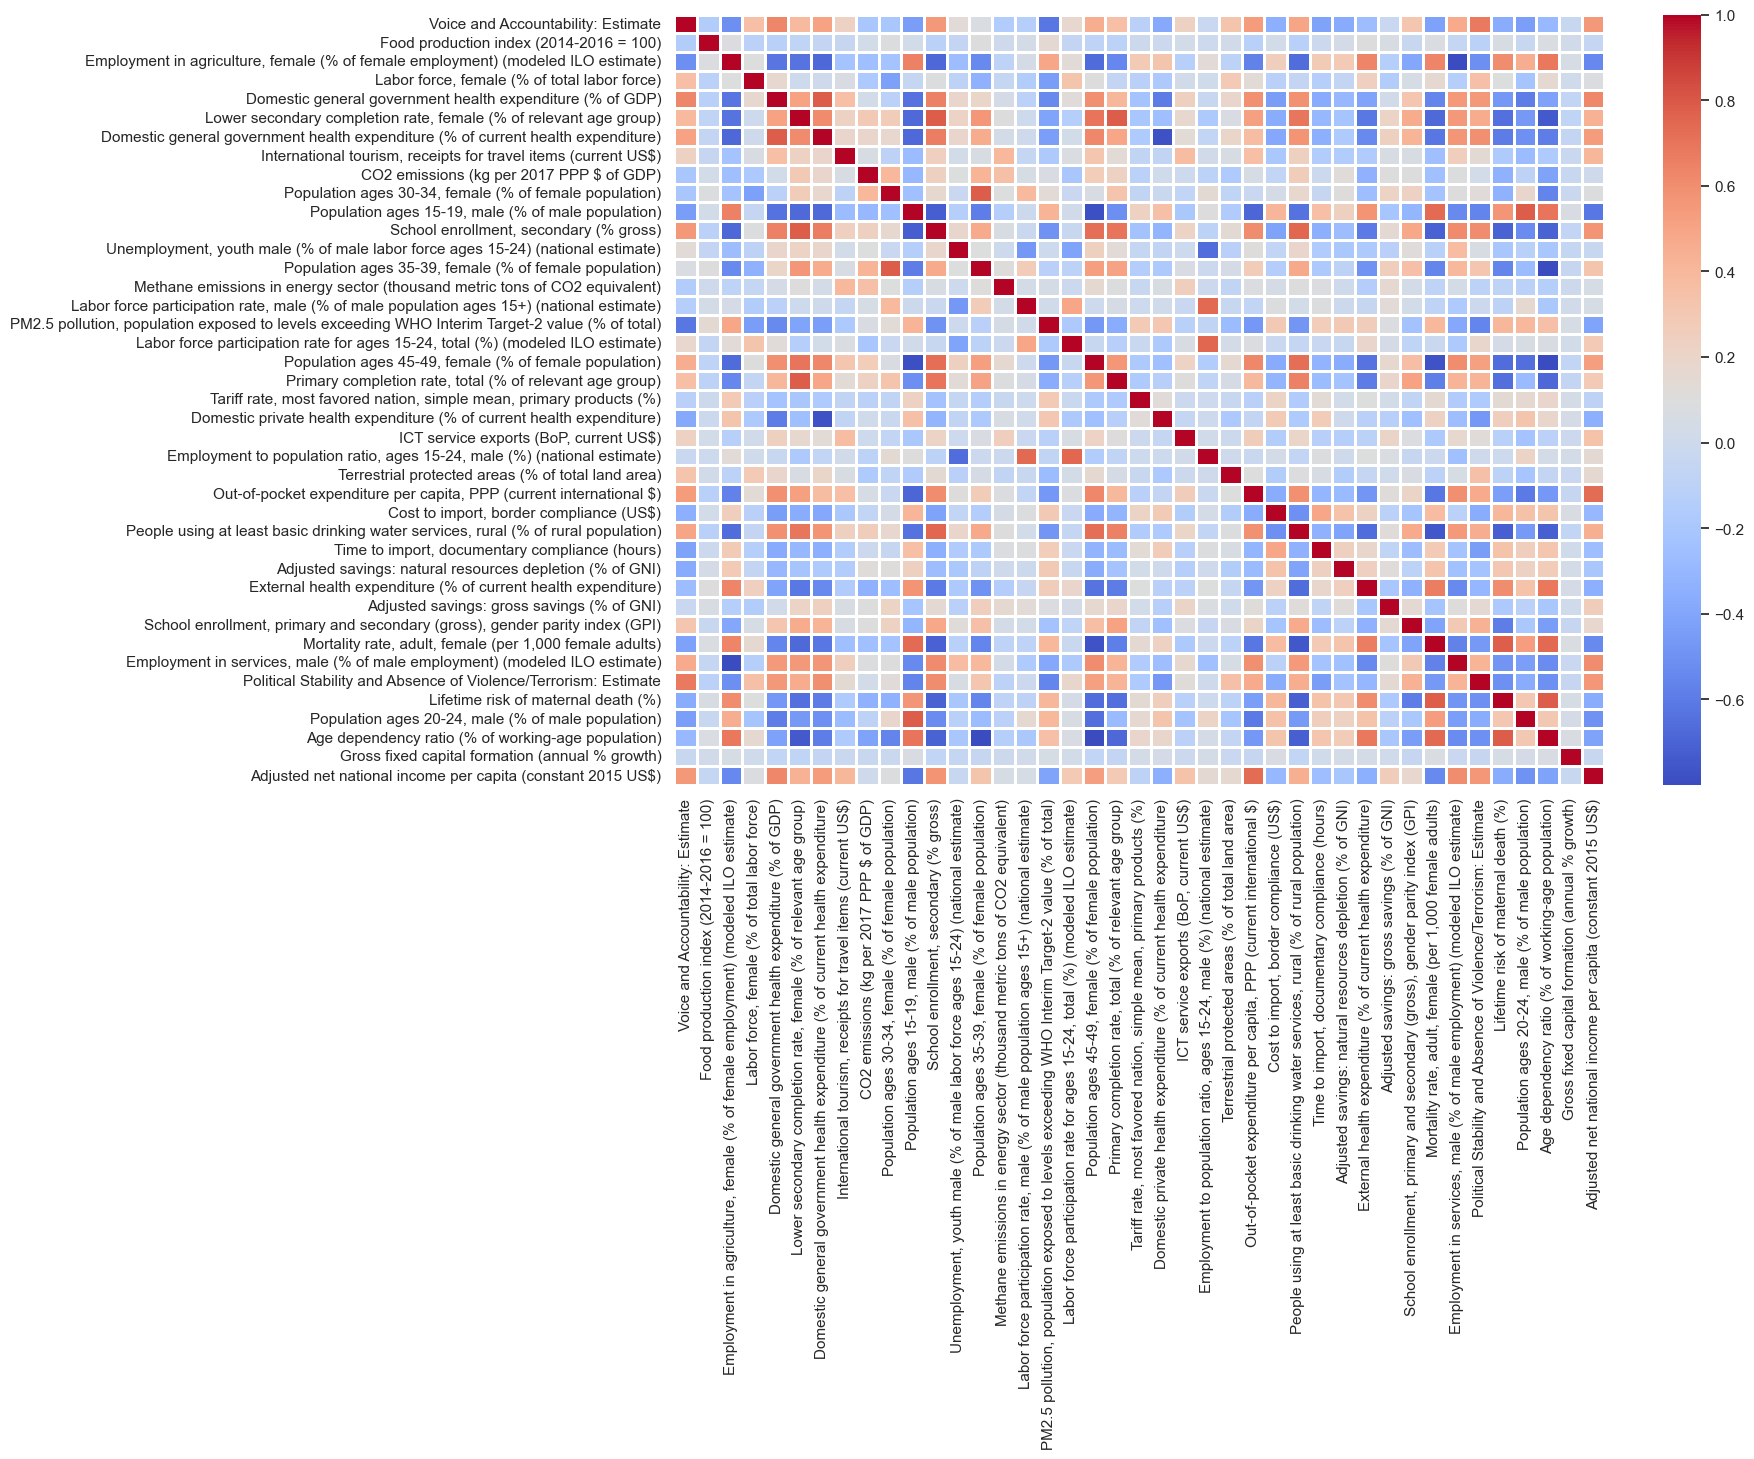

In [104]:
# Remaining features with correlation higher than threshold
threshold = threshold -.05
correlated_features = set()
correlation_matrix = df.drop(columns=['Year'],axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

correlation_matrix = df[correlated_features].corr()           

# draw the heatmap
plt.figure(figsize=(15, 10))
#sns.heatmap(correlation_matrix, annot=False, fmt='.1f', linewidths=1)
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.1f', linewidths=1)
plt.show()

#### Check For Distribution and Outliers

We have to many indicators to analyse the distribution of each one of them. We will focus on the distribution of the indicators that are the most correlated with CPI score as they are likely to be the most relevant for our analysis.


/var/folders/jc/s52zkjgs0jgbmgblzfhy27q80000gr/T/ipykernel_99982/3774189294.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



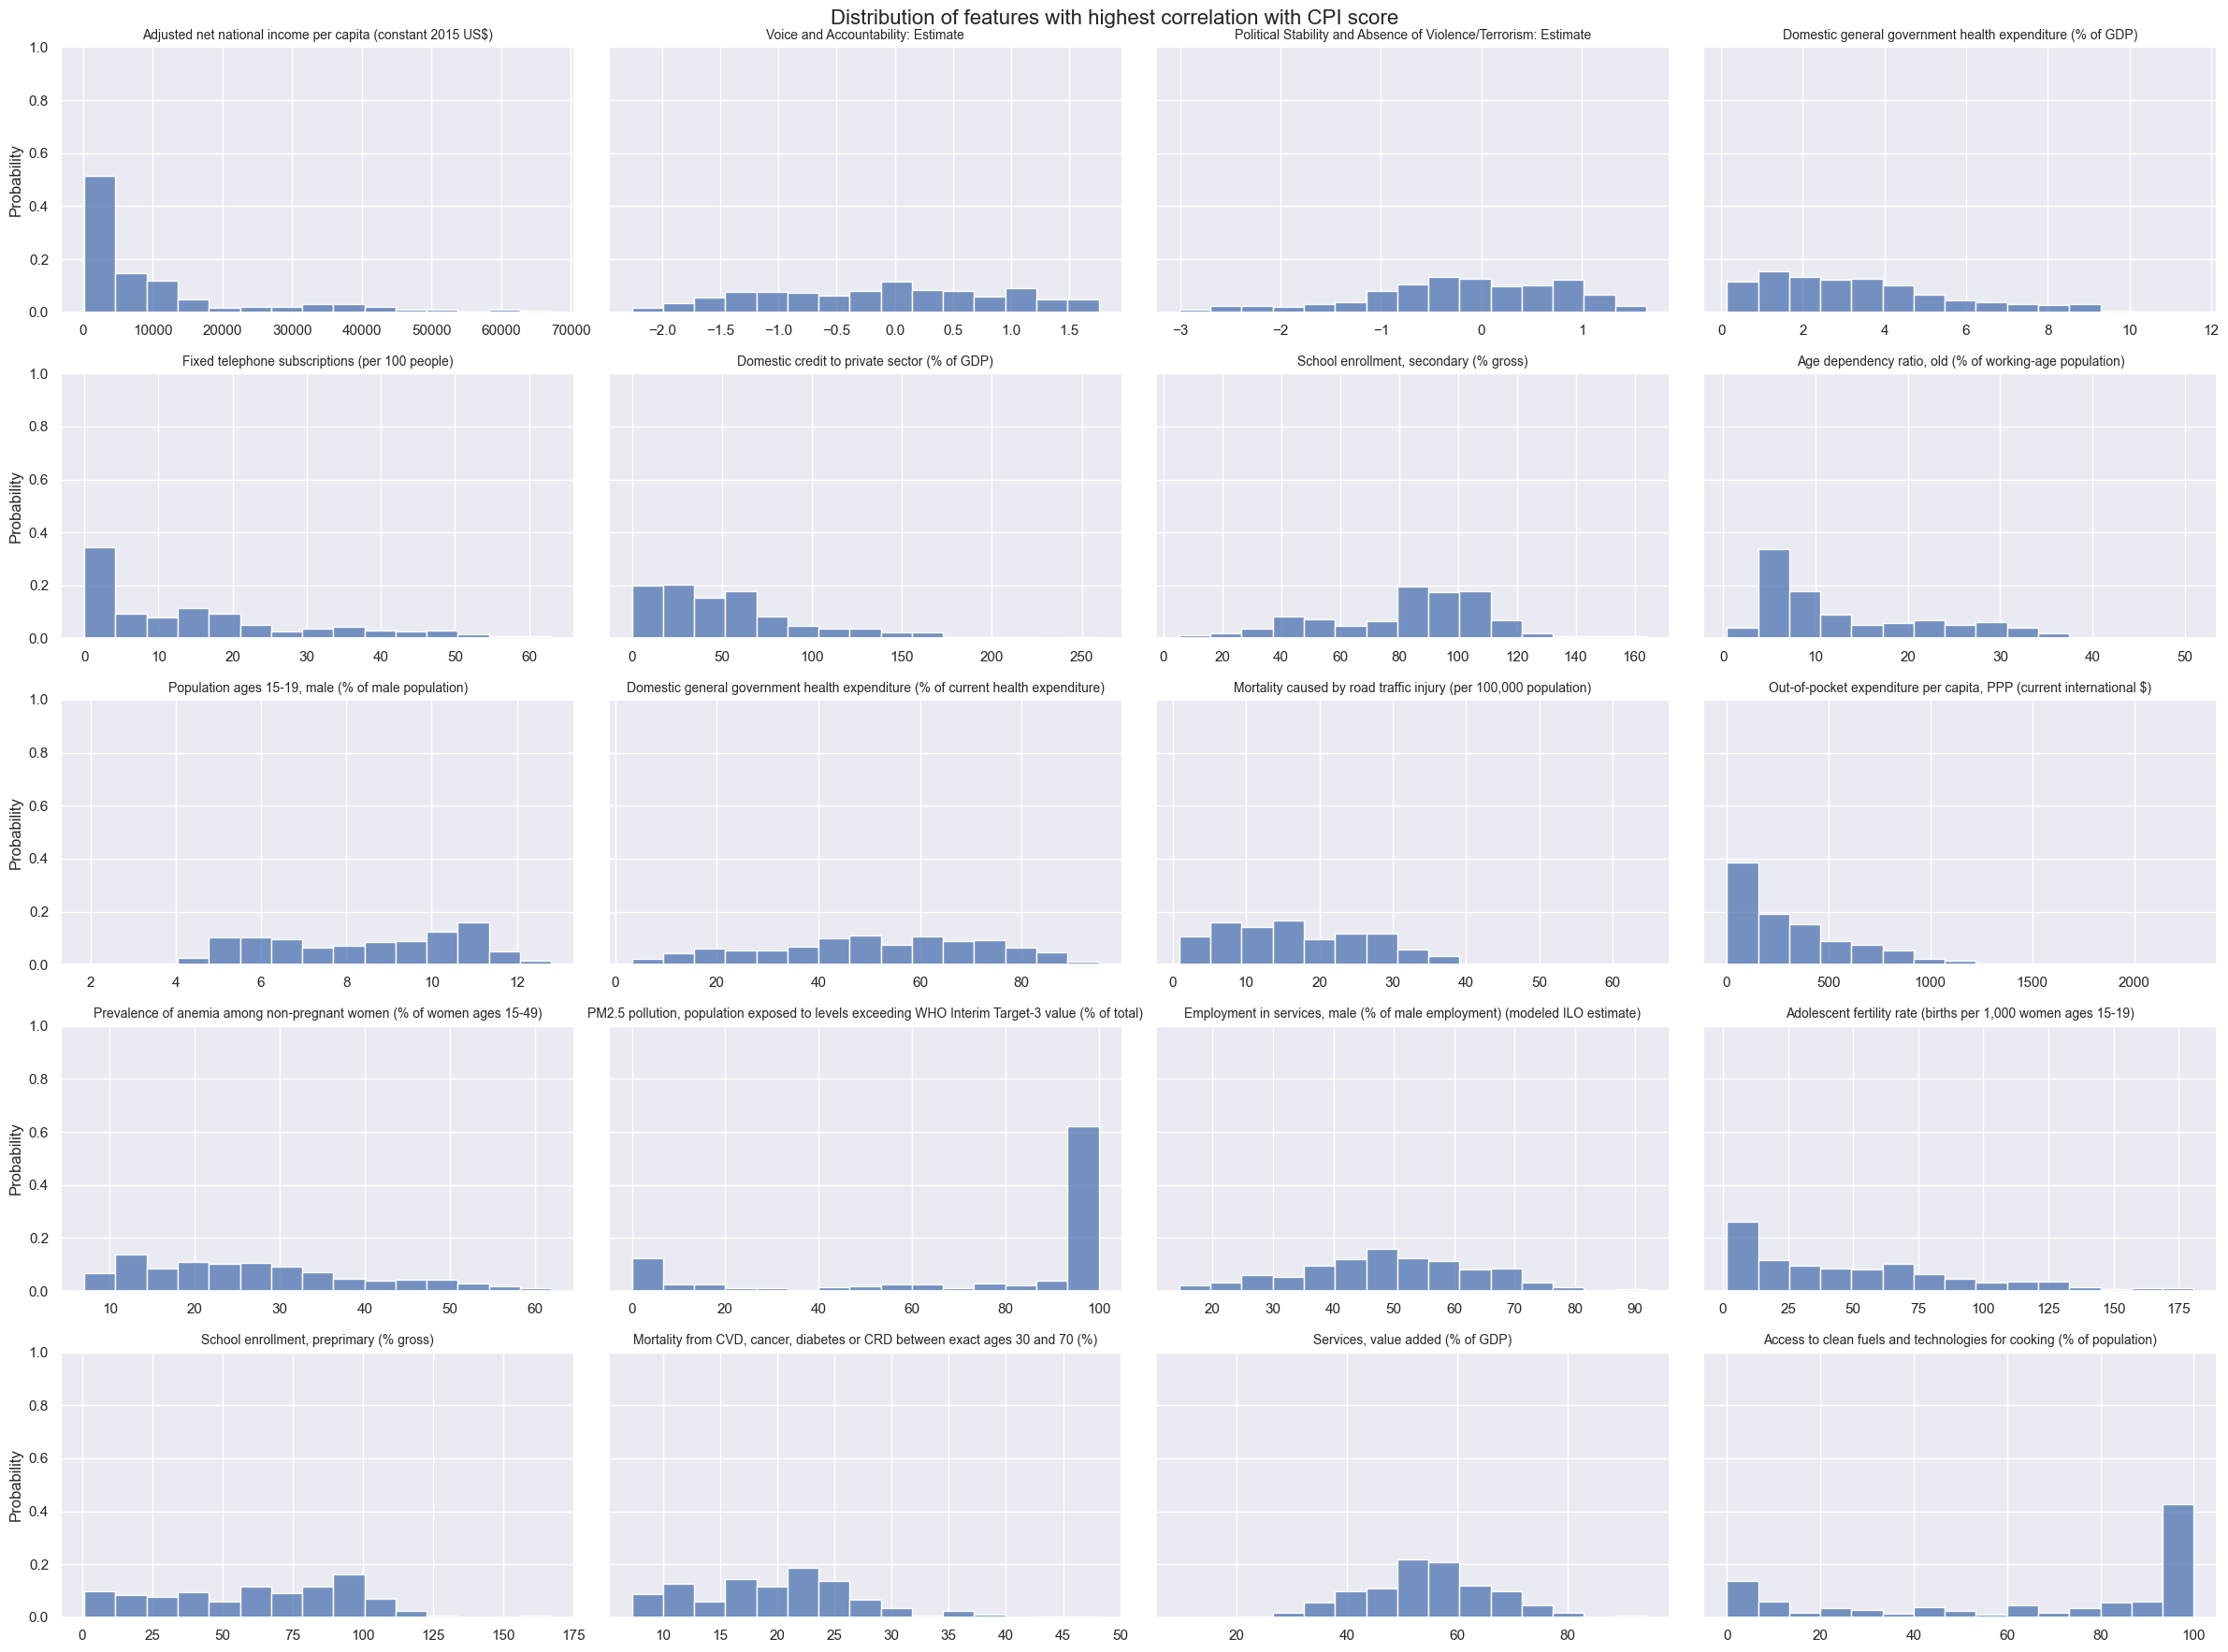

In [105]:
# get top 10 features with highest correlation between CPI score and features
correlation_matrix = df.corr().abs()
correlated_features = correlation_matrix['CPI score'].sort_values(ascending=False).iloc[1:21] # exclude CPI score (0)

# Create a grid of subplots
fig, axs = plt.subplots(5, 4, figsize=(24, 18))

# Flatten the 2D array of subplots into a 1D array
axs = axs.flatten()

# Loop over the columns and plot a histogram in each subplot
for i, col in enumerate(correlated_features.index):
    sns.histplot(df[col], ax=axs[i], bins=15, kde=False, stat='probability')
    axs[i].set_title(col, wrap=True, fontsize=10)
    if i%4 == 0 :
        axs[i].set_ylabel('Probability')
    else:
        axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].tick_params(left=False, labelleft=(i % 4 == 0))
    axs[i].set_ylim(0, 1)

# Remove the unused subplots
for i in range(len(correlated_features.index), len(axs)):
    axs[i].remove()

# add global title
fig.suptitle('Distribution of features with highest correlation with CPI score', fontsize=16)

# Adjust the spacing between subplots
fig.tight_layout()
plt.show()

## Benchmark Models

#### Feature preprocessing

For our analysis, we will ignore the country, ISO3, region and year columns.
 
All the features are numerical. 

However, each feature has a very different distribution. We will need to scale and normalize the data before using it in our analysis.

We will consider and compare several method to normalize heterogenous data such as StandardCaler, MinMaxScaler, RobustCaler and PowerTransformer.


In [106]:
# import libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance


In [107]:
# prepare data for training
X = df.drop(columns=['ISO3', 'Country Name', 'CPI score', 'Year', 'CPI score'])
y = df['CPI score']

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
# Preprocessing
categorical_features = ['Region']
ordinal_features = ['Income group']
income_ord = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']
numeric_features = X.columns.drop(categorical_features + ordinal_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('ord', OrdinalEncoder(categories=[income_ord]), ordinal_features)],
    remainder='passthrough')


Mean squared error: 15.97
Coefficient of determination: 0.96
MAE: 3.13


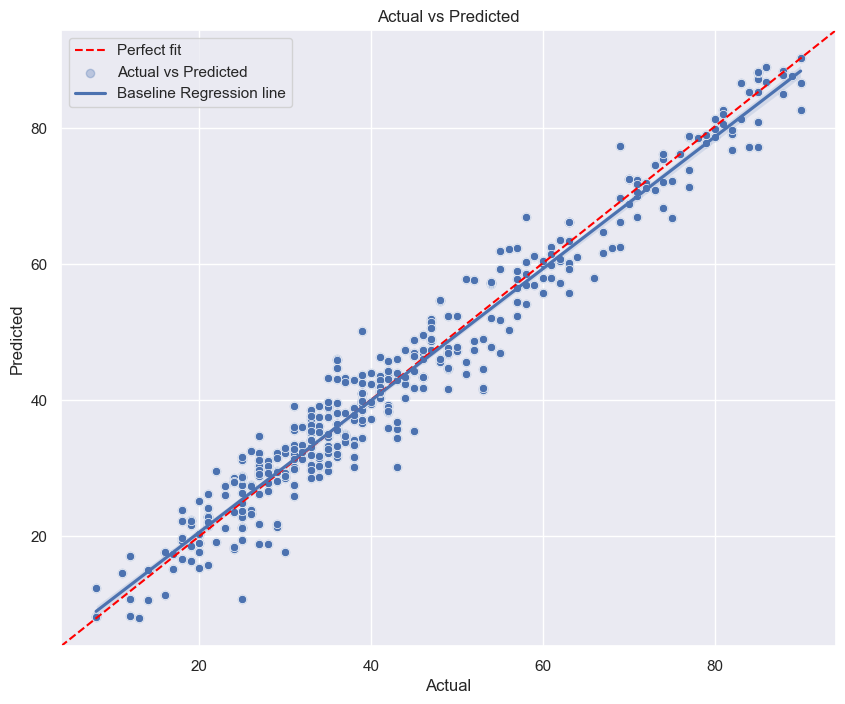

In [116]:
# create linear regression object
base_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# train the model using the training sets
base_model.fit(X_train, y_train)

# make predictions using the testing set
y_pred = base_model.predict(X_test)

# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

# MAE
print('MAE: %.2f' % np.mean(np.abs(y_test - y_pred)))

# plot actual vs predicted with line of best fit
plt.figure(figsize=(10, 8))

# plot the line of perfect fit
ax = plt.gca()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red', ls='--')

# plot regression line
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3})

# add legend
ax.legend(['Perfect fit', 'Actual vs Predicted','Baseline Regression line'], loc='upper left')
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [110]:
# Create function to evaluate models using cross-validation and grid search
# models: dictionary of models to evaluate
# preprocessor: preprocessor object
# X_train, y_train, X_test, y_test: train and test data
# scoring: scoring metric
def evalRegressorModels(models, preprocessor, X_train, y_train, X_test, y_test, scoring='neg_mean_squared_error'):

    # create dataframe to capture model metrics
    metrics = []

    # loop through the regressors dictionary items
    for model_name, (model, params) in models.items():
        # Create grid search
        print(f'Running grid search for {model_name}')
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # create a grid search object and fit it to the data using cross-validation
        grid = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, scoring=scoring)

        # fit the grid search object to the training data
        grid.fit(X_train, y_train)

        results = grid.cv_results_
        # capture the best estimator and the best parameters
        best_model = grid.best_estimator_
        best_params = grid.best_params_

        # predict on the test data using the best estimator
        train_pred = best_model.predict(X_train)
        test_pred = best_model.predict(X_test)

        MSE_train = mean_squared_error(y_train, train_pred)
        MSE_test = mean_squared_error(y_test, test_pred)
        R2_train = r2_score(y_train, train_pred)
        R2_test = r2_score(y_test, test_pred)
        MAE_train = mean_absolute_error(y_train, train_pred)
        MAE_test = mean_absolute_error(y_test, test_pred)

        # training time taken
        train_time = grid.cv_results_.get('mean_fit_time').mean()

        # append the model metrics to the model_metrics list
        metrics.append([model_name, best_params, train_time, MSE_train, MSE_test ,MAE_train, MAE_test, R2_train, R2_test , best_model, results])

    # create a dataframe from the model_metrics list
    return pd.DataFrame(metrics, columns=['model_name', 'best_params', 'train_time', 'MSE_train', 'MSE_test' ,'MAE_train', 'MAE_test', 'R2_train', 'R2_test' , 'model', 'results'])

##### Training Time With Different Models

In [111]:
# Evaluate multiple regression model using sklearn pipeline and gridsearchcv with 5-fold cross validation

# create parameter grid
regressors = {
    'LinearRegression': (LinearRegression(),
                        {'preprocessor__num': [StandardScaler(), RobustScaler()]}),
    'Ridge': (Ridge(),
            {'preprocessor__num': [StandardScaler(), RobustScaler()],
             'model__alpha': np.logspace(-3, 3, 7)}),
    'Lasso': (Lasso(max_iter=10000),
            {'preprocessor__num': [StandardScaler(), RobustScaler()],
            'model__alpha': np.logspace(-3, 3, 7)}),
    'ElasticNet': (ElasticNet(max_iter=10000),
                {'preprocessor__num': [StandardScaler(), RobustScaler()],
                'model__alpha': np.logspace(-3, 3, 7),
                'model__l1_ratio': np.linspace(0.1, 0.9, 9)}),
    'RandomForestRegressor': (RandomForestRegressor(),
                            {'preprocessor__num': [RobustScaler()],
                            'model__n_estimators': [10, 50, 100,200],
                            'model__max_depth': [None, 5, 10, 20, 50],
                            'model__max_features': ['sqrt', 'log2']}),
    'GradientBoostingRegressor': (GradientBoostingRegressor(),
                                {'preprocessor__num': [RobustScaler()],
                                'model__n_estimators': [10, 50, 100,200],
                                'model__max_depth': [None, 5, 10, 20, 50],
                                'model__max_features': ['sqrt', 'log2']}),
    'XGBRegressor': (XGBRegressor(),
                    {'preprocessor__num': [RobustScaler()],
                    'model__n_estimators': [10, 50, 100,200],
                    'model__max_depth': [None, 5, 10, 20, 50]}),
    'LGBMRegressor': (LGBMRegressor(),
                    {'preprocessor__num': [RobustScaler()],
                    'model__n_estimators': [10, 50, 100,200],
                    'model__max_depth': [None, 5, 10, 20, 50]}),
    'CatBoostRegressor': (CatBoostRegressor(verbose=False),
                        {'preprocessor__num': [RobustScaler()],
                        'model__n_estimators': [10, 50, 100,200]})
}

model_metrics = evalRegressorModels(regressors, preprocessor, X_train, y_train, X_test, y_test)
model_metrics[['model_name', 'best_params', 'train_time', 'MSE_train', 'MSE_test', 'MAE_train' ,'MAE_test', 'R2_test' ]]

Running grid search for LinearRegression
Running grid search for Ridge
Running grid search for Lasso
Running grid search for ElasticNet
Running grid search for RandomForestRegressor
Running grid search for GradientBoostingRegressor
Running grid search for XGBRegressor


/Users/mgomez17/.pyenv/versions/3.9.5/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Running grid search for LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70147
[LightGBM] [Info] Number of data points in the train set: 1232, number of used features: 313
[LightGBM] [Info] Start training from score 42.870130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70229
[LightGBM] [Info] Number of data points in the train set: 1232, number of used features: 313
[LightGBM] [Info] Start training from score 42.357143
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of tes

,model_name,best_params,train_time,MSE_train,MSE_test,MAE_train,MAE_test,R2_test
0,LinearRegression,{'preprocessor__num': RobustScaler()},0.065550,9.354294,15.238966,2.404112,3.057579,0.958919
1,Ridge,"{'model__alpha': 0.1, 'preprocessor__num': Sta...",0.036497,9.356292,15.211987,2.405616,3.057744,0.958992
2,Lasso,"{'model__alpha': 0.001, 'preprocessor__num': S...",0.629577,9.393559,15.041533,2.415001,3.048373,0.959452
3,ElasticNet,"{'model__alpha': 0.001, 'model__l1_ratio': 0.3...",0.809074,9.435387,15.060685,2.419662,3.057782,0.959400
4,RandomForestRegressor,"{'model__max_depth': 20, 'model__max_features'...",0.759572,0.887632,5.087751,0.713628,1.748892,0.986285
5,GradientBoostingRegressor,"{'model__max_depth': 10, 'model__max_features'...",1.019014,0.001831,4.260944,0.030756,1.517349,0.988513
6,XGBRegressor,"{'model__max_depth': 5, 'model__n_estimators':...",6.476775,0.006231,5.824543,0.056286,1.785488,0.984298
7,LGBMRegressor,"{'model__max_depth': None, 'model__n_estimator...",1.875358,0.071840,5.463946,0.172113,1.690589,0.985270
8,CatBoostRegressor,"{'model__n_estimators': 200, 'preprocessor__nu...",7.627852,0.958821,5.940367,0.779320,1.855172,0.983986


##### Target Best Model

In [112]:
# draw a chart with x as time to train y as model performance (test_R2) buble size as Train_R2-Test_R2
model_metrics['Overfitting Ratio'] = 1 - (model_metrics['R2_test'] / model_metrics['R2_train'])

fig = px.scatter(model_metrics, x="train_time", y="R2_test", size="Overfitting Ratio", color="model_name",
                    hover_name="model_name", log_x=True, size_max=50,
                    width=600, height=400, title='Model performance vs. time to train')
fig.update_layout(
    xaxis_title="Time to train (seconds)",
    yaxis_title="Test R2",
    legend_title="Model"
)
fig.add_annotation(
    x=-0.3,
    y=1,
    # # align left

    text="Bubble size represents overfitting ratio",
    showarrow=False
)
fig.show()
fig.write_image("images/performance_vs_time_training.png")


The best model is `GradientBoostingRegressor` as it combines the best performance with the lowest overfitting as well as a limited training time.

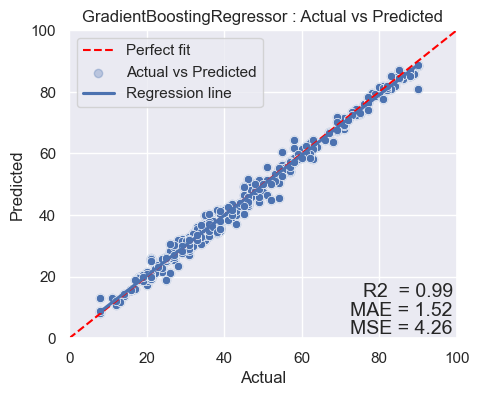

In [113]:
bestModelIndex = 5
y_pred = model_metrics['model'][bestModelIndex].predict(X_test)
model_name = model_metrics['model_name'][bestModelIndex]

# calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

# plot actual vs predicted with line of best fit
plt.figure(figsize=(5, 4))
# plot the line of perfect fit
ax = plt.gca()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red', ls='--')
# plot regression line
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3})
# add legend
ax.legend(['Perfect fit', 'Actual vs Predicted','Regression line'], loc='upper left')
sns.scatterplot(x=y_test, y=y_pred)
# add metrics to plot
plt.text(99, 0, 'MSE = {:.2f}'.format(mse), fontsize=14, ha='right', va='bottom')
plt.text(99, 6, 'MAE = {:.2f}'.format(mae), fontsize=14, ha='right', va='bottom')
plt.text(99, 12, 'R2  = {:.2f}'.format(r2), fontsize=14, ha='right', va='bottom')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(model_name + ' : Actual vs Predicted')
plt.savefig("images/ActualVsPredicted.png")
plt.show()

#### Feature Importance For This Analysis

In [114]:
best_model = model_metrics.iloc[bestModelIndex].model
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

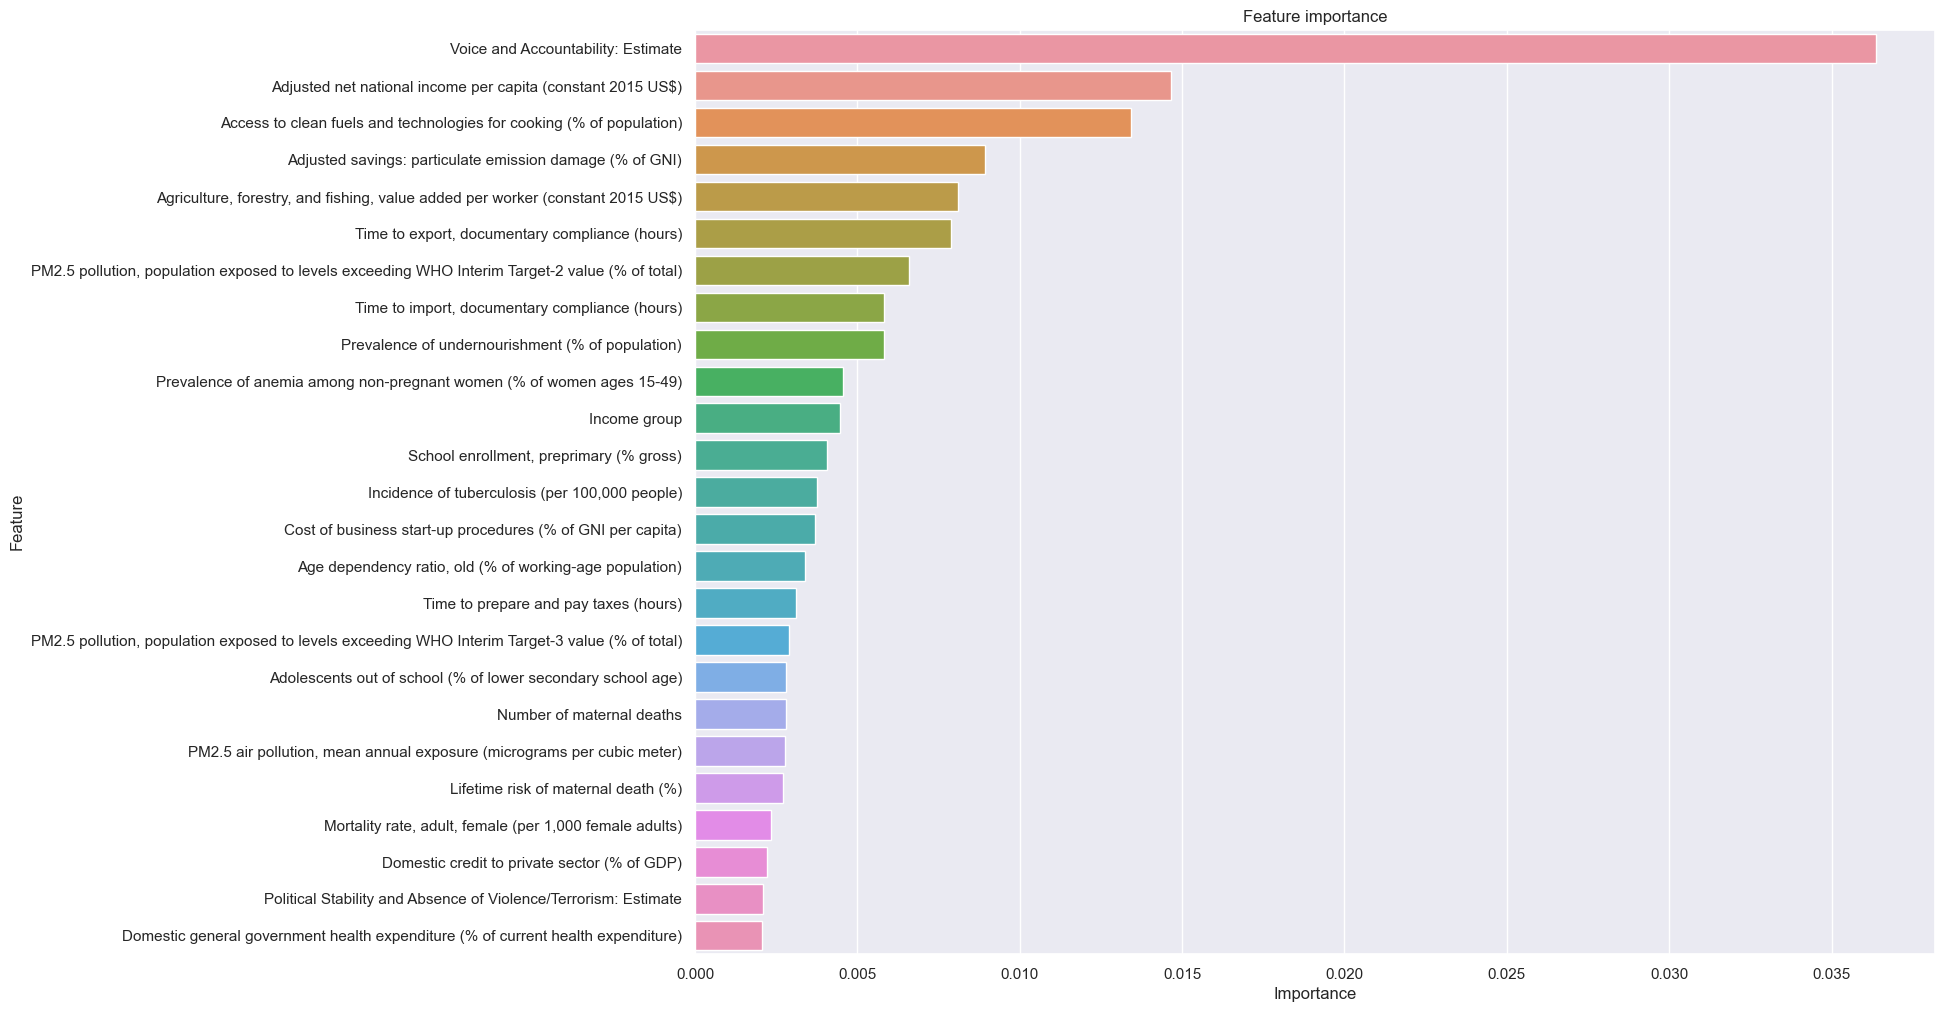

1. Voice and Accountability: Estimate
2. Adjusted net national income per capita (constant 2015 US$)
3. Access to clean fuels and technologies for cooking (% of population)
4. Adjusted savings: particulate emission damage (% of GNI)
5. Agriculture, forestry, and fishing, value added per worker (constant 2015 US$)
6. Time to export, documentary compliance (hours)
7. PM2.5 pollution, population exposed to levels exceeding WHO Interim Target-2 value (% of total)
8. Time to import, documentary compliance (hours)
9. Prevalence of undernourishment (% of population)
10. Prevalence of anemia among non-pregnant women (% of women ages 15-49)
11. Income group
12. School enrollment, preprimary (% gross)
13. Incidence of tuberculosis (per 100,000 people)
14. Cost of business start-up procedures (% of GNI per capita)
15. Age dependency ratio, old (% of working-age population)
16. Time to prepare and pay taxes (hours)
17. PM2.5 pollution, population exposed to levels exceeding WHO Interim Target-3 va

In [115]:
# create dataframe of feature importance 
nb_features = 25
feature_names = X_test.columns
importance = result.importances_mean
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
# feature_importance.reset_index(drop=True, inplace=True)

# plot top 20 features by importance
plt.figure(figsize=(16, 12))
sns.barplot(x='importance', y='feature', data=feature_importance.iloc[:nb_features])
plt.xlabel('Importance')
plt.ylabel('Feature', wrap=True,  ha='right')
plt.title('Feature importance')
plt.savefig("images/FeatureImportance.png")
plt.show()

#print the top features
for i in range(nb_features):
    print(str(i+1) + '. ' + feature_importance.iloc[i].feature)

